In [15]:
path_to_muograph = "../"
import sys
sys.path.insert(1, path_to_muograph)

import numpy as np
import math

%reload_ext autoreload
%autoreload 2

![alternative text](../images/muograph_logo.png)


**<h1><center>POCA: tutorial</center></h1>**

The `EM` class is used to perform the **Expectation-Maximisation algorithm**, using both the **tracking information** provided by the `TrackingMST`and `Tracking_EM`. The latter computes the different geometries of interaction of muons with the volume voxels (`L`,`T`), as well as the weight matrix for each muon-voxel pair `W` needed for the maximisation step of the `EM` reconstruction algorithm.
The `POCA` class is instantiated at first, in order to obtain the PoCA locations to be used in `Tracking_EM`

### **I - Instanciation** 

First, let's instanciante the `TrackingMST` class. At first, we will consider a detector with perfect **spatial resolution** and **efficiency**:

In [16]:
csv_file = '../muograph/data/iron_barrel/barrel_and_cubes_scattering.csv'

from muograph.hits.hits import Hits

hits_in = Hits(
    csv_filename = csv_file,  # The csv file
    plane_labels = (0, 1, 2),  # Include hits from first planes 0, 1 and 2
    input_unit = "mm",  # The distance unit in the csv file.
)
hits_in

Collection of hits from 137,033 muons on 3 detector panels.

In [17]:
hits_out = Hits(
    csv_filename = csv_file,  # The csv file
    plane_labels = (3, 4, 5),  # Include hits from first planes 0, 1 and 2
    input_unit = "mm",  # The distance unit in the csv file.
)
hits_out

Collection of hits from 137,033 muons on 3 detector panels.

In [18]:
from muograph.tracking.tracking import Tracking

tracks_in = Tracking(label="above", hits=hits_in)
tracks_out = Tracking(label="below", hits=hits_out)

tracks_in, tracks_out

(Collection of tracks from 137,033 muons 
  with perfect angular resolution.,
 Collection of tracks from 137,033 muons 
  with perfect angular resolution.)

In [19]:
output_dir = "../output_test/"
from muograph.tracking.tracking import TrackingMST
mst = TrackingMST(trackings=(tracks_in, tracks_out))
mst

Collection of tracks from 137,033 muons 
 with perfect angular resolution.
 with perfect tracking efficiency

The `POCA` class takes the following **arguments**:


- `tracking (Optional[TrackingMST])`: Instance of the TrackingMST class.

- `voi (Optional[Volume])`: Instance of the Volume class. If provided, muon events with poca locations outside the voi will be filtered out, the number of poca locations per voxel `n_poca_per_vox` as well as the voxel indices of each poca location will be computed.

- `poca_file (Optional[str])`: The path to the poca.hdf5 to load attributes from.

- `output_dir (Optional[str])`: Path to a directory where to save POCA attributes in a hdf5 file.

Let's instanciate the `POCA` class using an instances of `TrackingMST` and `Volume` class.

In [20]:
from muograph.volume.volume import Volume
voi = Volume(
    position = (0, 0, -1200), # The position of the Volume of interest.
    dimension = (900, 600, 600), # The dimensions of the Volume of interest.
    voxel_width = 30) # The voxel size.

## **Tracking EM**

In [21]:
from muograph.reconstruction.tracking_em_test import TrackingEM

# use les muons to speed things up 
mst._filter_muons(mask=mst.dtheta > 1 * math.pi / 180)

t = TrackingEM(
    voi=voi,
    tracking=mst,
)


## **`all_poca`**

The **poca points** associated to ALL the tracks in `self.tracking`.

Usually when computing the poca points, we have to get rid of:

 - **Parallel events**: Poca point associated to parallel tracks cannot be computed.
 - **POCAs outside the voi**: Some POCA points land outisde the volume of interest.
  
As a consequence, `POCA` class only has 77,014 events whereas `TrackingMST` has 137,033 events.

`all_pocas` contains the same number of of events as `TrackingMST`.

In [22]:
t.tracking

Collection of tracks from 9,585 muons 
 with perfect angular resolution.
 with perfect tracking efficiency

In [23]:
t.all_poca.size(), t.poca.poca_points.size()

(torch.Size([9585, 3]), torch.Size([9478, 3]))

In [24]:
t.poca

Collection of 9478 POCA locations.

## **`xyz_in_out_voi`**

Coordinates of the muon incoming/outgoing track when reaching the top / bottom of the voi.


- Coordinate of the muon incoming track when reaching the top of the voi:
            `xyz_in_out_voi[0][:, 1]`
- Coordinate of the muon incoming track when reaching the bottom of the voi:
`xyz_in_out_voi[0][:, 0]`
- Coordinate of the muon outgoing track when reaching the top of the voi:
`xyz_in_out_voi[1][:, 1]`
- Coordinate of the muon outgoing track when reaching the bottom of the voi:
`xyz_in_out_voi[1][:, 0]`

In [25]:
t.xyz_in_out_voi[0][:, 1], t.xyz_in_out_voi[0][:, 0] 

(tensor([[ 233.7290,   82.9040, -900.0000],
         [-110.6255,  -89.4229, -900.0000],
         [-133.4336,   17.9461, -900.0000],
         ...,
         [ -94.1943,  180.8167, -900.0000],
         [-154.1976, -125.4682, -900.0000],
         [-191.0845, -110.0090, -900.0000]]),
 tensor([[   35.8909,   202.3849, -1500.0000],
         [  -31.4045,    81.0611, -1500.0000],
         [ -215.4182,    85.1786, -1500.0000],
         ...,
         [ -156.9216,   327.3326, -1500.0000],
         [ -155.3616,   104.8969, -1500.0000],
         [ -212.2298,   198.1599, -1500.0000]]))

## **`xyz_enters_voi` & `xyz_exits_voi`**

Coordinates of the muon incoming track when entering the voi.

In [26]:
t.xyz_enters_voi.size()

torch.Size([9585, 3])

In [27]:
t.xyz_exits_voi.size()

torch.Size([9585, 3])

## **`intersection_coordinates`**

Coordinates of the intersections points of both, incoming and outgoing track of each muon with the faces of the voxels.

It is a list of tensors, where each element of the list corresponds to one muon and its intersections points.

In [28]:
type(t.intersection_coordinates), len(t.intersection_coordinates)

Number of voxels per axes: nx=30, ny=20, nz=20
Dimension X planes before expand: torch.Size([31])
Dimension x0 coord before expand: torch.Size([9585])
Dimension x_in coord before expand: torch.Size([9585])
Dimension X planes after expand (x coord): torch.Size([1, 31])
Dimension x0 coord after expand: torch.Size([9585, 1])
Dimension x_in coord after expand: torch.Size([9585, 1])
Dimension t coord: torch.Size([9585, 31])
Dimension y coord: torch.Size([9585, 31])
Dimension z coord: torch.Size([9585, 31])
Dimension inters_points_X_in: torch.Size([9585, 31, 3])
Dimension total_inters_point_in: torch.Size([9585, 73, 3])
tensor([[   34.4799,   193.3482, -1500.0000],
        [   44.5848,   188.0132, -1470.0000],
        [   54.6898,   182.6782, -1440.0000],
        [   59.7627,   180.0000, -1424.9394],
        [   60.0000,   179.8747, -1424.2349],
        [   64.7948,   177.3433, -1410.0000],
        [   74.8998,   172.0083, -1380.0000],
        [   85.0047,   166.6734, -1350.0000],
        [ 

(list, 9585)

## **`triggered_voxels`**

A list of tensors, where each element of the list corresponds to one muon and its triggered voxels (the indices of the triggered voxels).

In [29]:
type(t.triggered_voxels_BETA), len(t.triggered_voxels_BETA)

Intersection coordinates type: <class 'list'>, Triggered type: <class 'list'>
Intersection coordinates element type: <class 'torch.Tensor'>, Triggered voxels element type: <class 'torch.Tensor'>


(list, 9585)

## Plot event ##

Here we have a 3D plot that shows the path of a number of random muons, the intersection points and the triggered voxels.

After, we have some 2D plots that helps us view that everything is correct.

[2740]


<IPython.core.display.Javascript object>


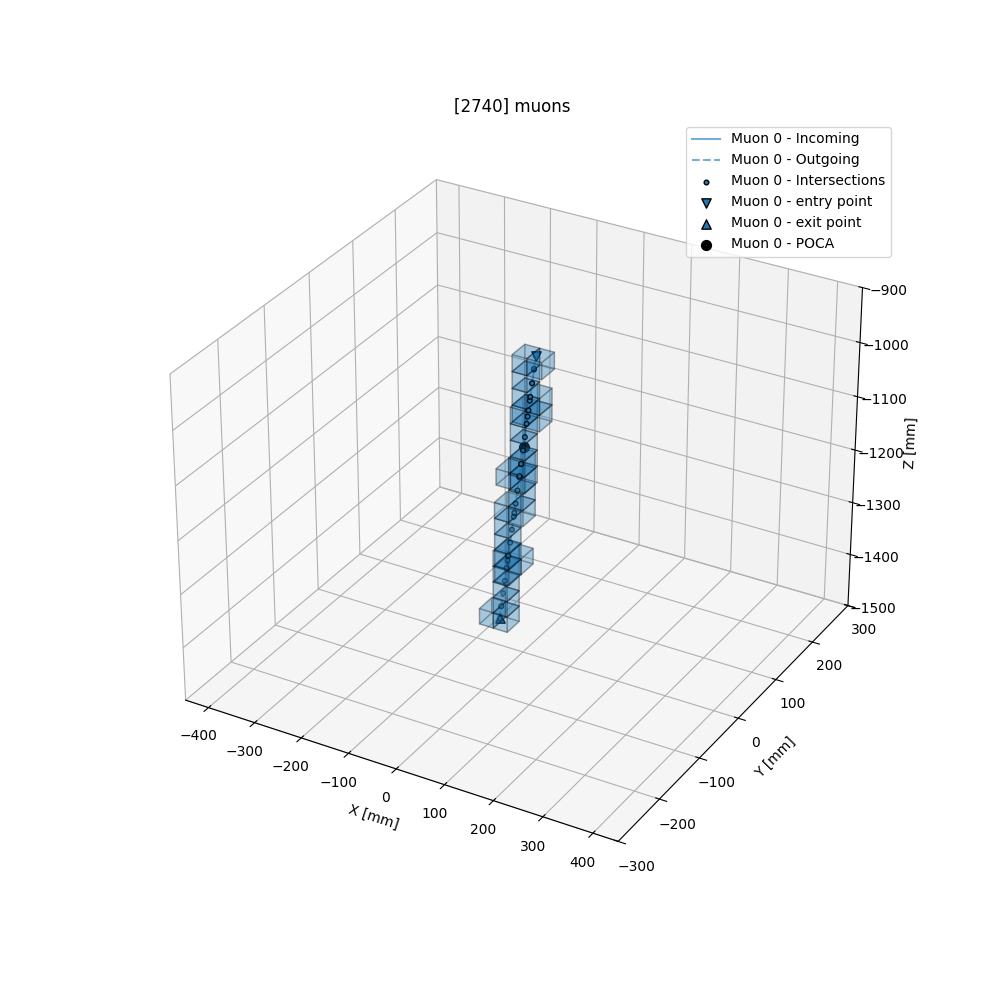

In [19]:
# we can interact with the plot
%matplotlib notebook
num_muons = 1 # select the number of muons you want to plot
num_events = np.random.choice(t.xyz_enters_voi.size(0), num_muons, replace=False)
t.plot_3D_inters_all_muons(num_events) # the functions chooses

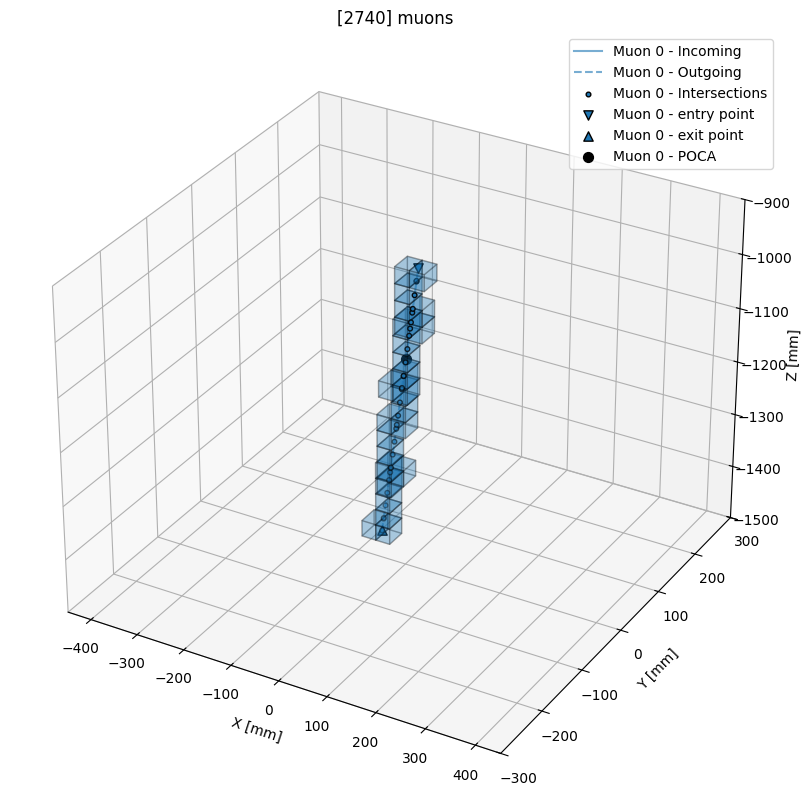

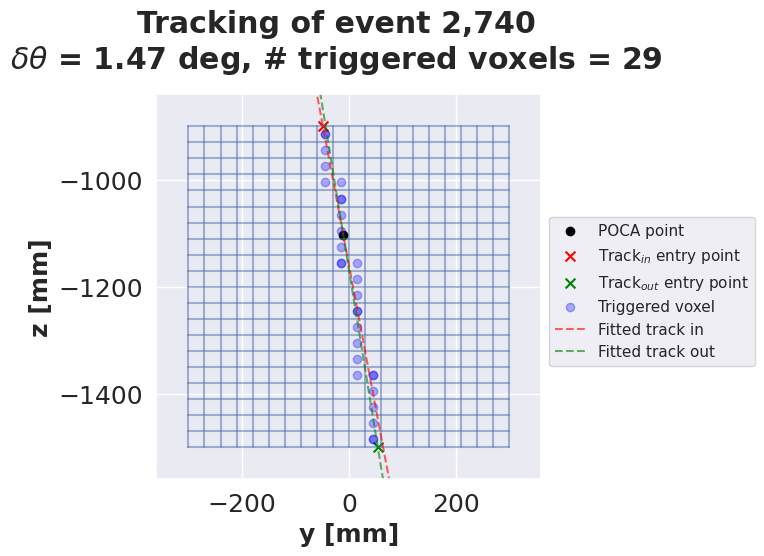

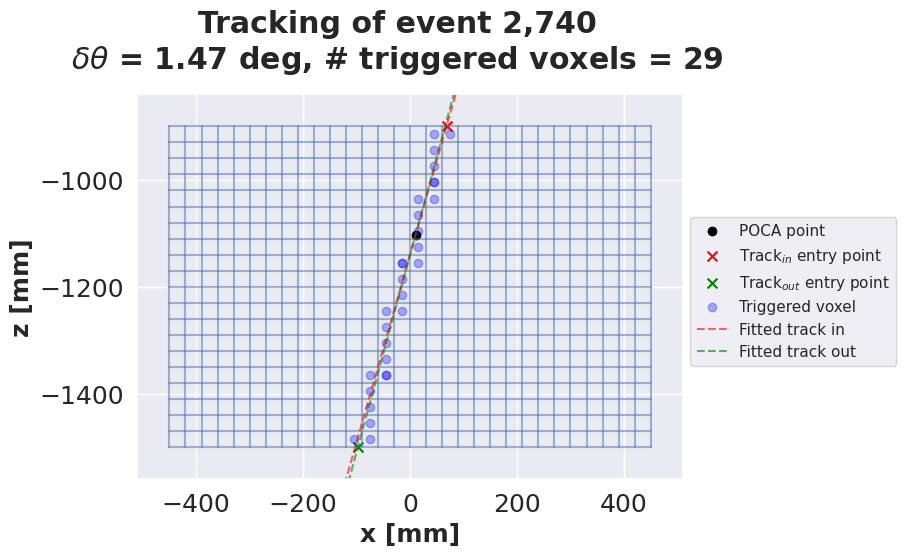

In [21]:
%matplotlib inline
num_event = num_events[0]
t.plot_event(
    event=num_event,
    proj="YZ",
)
t.plot_event(
    event=num_event,
    proj="XZ",
)

Some muons enter by the side of the volume not from the top:

1 - First we define a mask that selects muons that have a x position outside of the volume when reaching the top of the volume.

In [16]:
# Create a mask that selects only events entering from the left in x
mask_side = (t.xyz_in_out_voi[0][:, 1, 0] < voi.xyz_min[0])

mask_side, mask_side.size()

(tensor([False, False, False,  ..., False, False, False]), torch.Size([9585]))

In [17]:
# Create a mask that selects only events exiting the voi from the RIGHT in x
mask_side_r = (t.xyz_in_out_voi[1][:, 0, 0] > voi.xyz_max[0])

mask_side_r, mask_side_r.size()

(tensor([False, False, False,  ..., False, False, False]), torch.Size([9585]))

2 - Get the index of events for which the mask is true, using the `nonzero()` method.

In [18]:
events_left = mask_side.nonzero().flatten()

type(events_left), events_left.size(), events_left

(torch.Tensor,
 torch.Size([68]),
 tensor([  83,  260,  581,  767, 1011, 1030, 1062, 1225, 1320, 1547, 1676, 1818,
         1848, 2022, 2358, 2360, 2376, 2738, 3051, 3059, 3141, 3254, 3331, 3492,
         3512, 3535, 3548, 3554, 3851, 3918, 4037, 4202, 4347, 4349, 4358, 4514,
         4729, 5052, 5264, 5426, 5573, 5581, 5884, 5923, 6045, 6071, 6332, 6426,
         6470, 6525, 7171, 7518, 7646, 7659, 7937, 7986, 8196, 8226, 8404, 8502,
         8908, 8920, 8969, 8984, 9102, 9267, 9357, 9523]))

In [19]:
events_right = mask_side_r.nonzero().flatten()

type(events_right), events_right.size(), events_right

(torch.Tensor,
 torch.Size([103]),
 tensor([  11,   35,  287,  290,  378,  430,  621,  643,  934,  999, 1153, 1163,
         1261, 1277, 1301, 1738, 1868, 2004, 2049, 2228, 2321, 2331, 2579, 2626,
         2677, 2755, 2783, 2791, 2830, 3047, 3172, 3185, 3213, 3229, 3244, 3322,
         3339, 3666, 3669, 3734, 3741, 3769, 3868, 3980, 4021, 4039, 4143, 4179,
         4185, 4216, 4443, 4469, 4535, 4554, 4758, 4784, 4860, 4952, 5133, 5205,
         5242, 5276, 5453, 5575, 5649, 5855, 5916, 6117, 6457, 6479, 6514, 6584,
         6630, 6669, 6764, 6911, 7138, 7154, 7225, 7323, 7587, 7933, 7965, 7989,
         7990, 8158, 8173, 8194, 8371, 8443, 8459, 8610, 8668, 8785, 8842, 8867,
         8898, 8913, 8914, 9094, 9288, 9546, 9571]))

3 - Now let's plot:

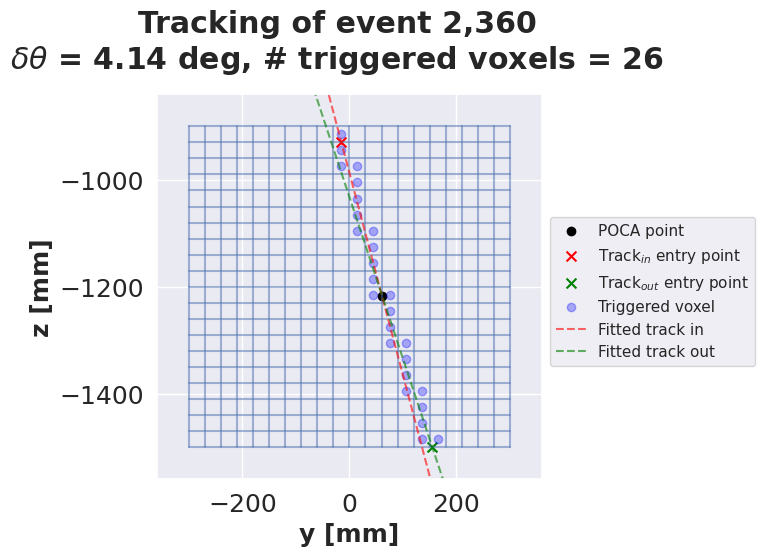

In [20]:
event_left = events_left[np.random.randint(len(events_left))]

t.plot_event(
    event=event_left,
    proj="YZ",
)

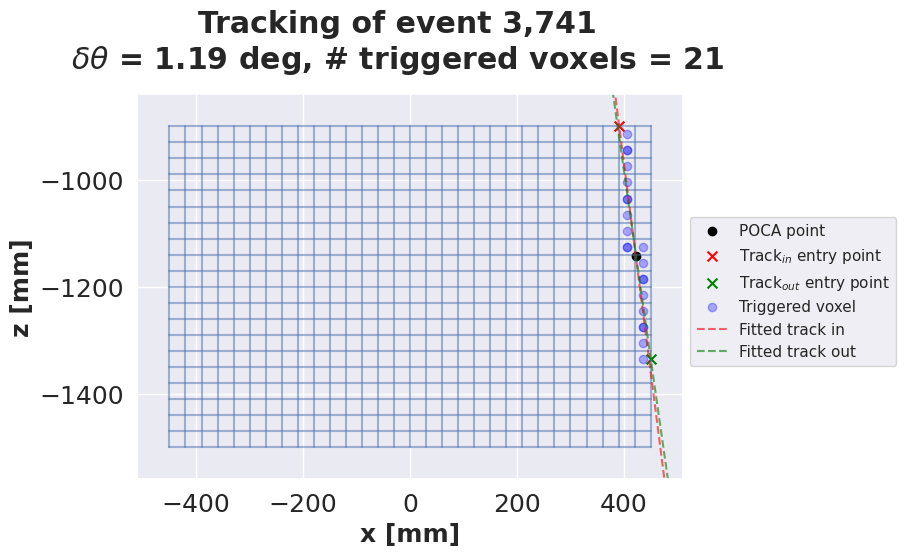

In [21]:
event_right = events_right[np.random.randint(len(events_right))]

t.plot_event(
    event=event_right,
    proj="XZ",
)

## Things I have been doing in order to understand some variables

In [22]:
type(t.triggered_voxels),len(t.triggered_voxels),len(t.triggered_voxels[0]),len(t.triggered_voxels[1])


Sub-volumes



Voxel triggering


(list, 9585, 26, 18)

In [23]:
t.triggered_voxels[3047]

array([[28, 14, 13],
       [28, 14, 14],
       [28, 14, 15],
       [28, 14, 16],
       [28, 14, 17],
       [28, 14, 18],
       [29, 13,  7],
       [29, 13,  8],
       [29, 13,  9],
       [29, 13, 10],
       [29, 14, 11],
       [29, 14, 12]])

In [44]:
# Para calcular los índices de los triggered voxels, método de Zahraa
# Coordenada z: restar la coordenada z_min a la coordeanda z_punto_intersección y dividirlo entre el num voxels en el eje z
# Coordenada x,y: 
print(voi.voxel_centers[0][0][0][0], voi.voxel_centers[0][0][0][1], voi.voxel_centers[0][0][0][2])
print(voi.voxel_centers[0][0][1][0], voi.voxel_centers[0][0][1][1], voi.voxel_centers[0][0][1][2])
print(voi.voxel_centers[0][1][1][0], voi.voxel_centers[0][1][1][1], voi.voxel_centers[0][1][1][2])
print(voi.voxel_centers[1][1][1][0], voi.voxel_centers[1][1][1][1], voi.voxel_centers[1][1][1][2])
print(voi.voxel_centers.size()[0])
print(voi.voxel_centers[10][10][10][0], voi.voxel_centers[10][10][10][1], voi.voxel_centers[10][10][10][2])

tensor(-435.) tensor(-285.) tensor(-1485.)
tensor(-435.) tensor(-285.) tensor(-1455.)
tensor(-435.) tensor(-255.) tensor(-1455.)
tensor(-405.) tensor(-255.) tensor(-1455.)
30
tensor(-135.) tensor(15.) tensor(-1185.)


In [35]:
coord = t.intersection_coordinates[5546]
print(coord)
x = coord[:,0]
y = coord[:,1]
z = coord[:,2]
x0 = x[0]; x1 = x[1]
y0 = y[0]; y1 = y[1]
z0 = z[0]; z1 = z[1]
X = x0+(abs(x0-x1)/2)
Y = y0+(abs(y0-y1)/2)
Z = z0+(abs(z0-z1)/2)
print(X,Y,Z)
x_idx = np.floor((X+(900/2))/30)
y_idx = np.floor((Y+(600/2))/30)
z_idx = np.floor((Z+(-1500))/30)
print(x_idx)
print(y_idx)
print(z_idx)
print('----------')
x_idx = np.floor((x+(900/2))/30)
y_idx = np.floor((y+(600/2))/30)
z_idx = np.floor((z+(-1500))/30)
print(x_idx)
print(y_idx)
print(z_idx)

tensor([[ -300.2240,  -152.3058,  -900.0000],
        [ -304.0746,  -155.0716,  -930.0000],
        [ -307.9252,  -157.8375,  -960.0000],
        [ -311.7758,  -160.6033,  -990.0000],
        [ -315.6264,  -163.3691, -1020.0000],
        [ -319.4770,  -166.1350, -1050.0000],
        [ -323.3276,  -168.9008, -1080.0000],
        [ -327.1782,  -171.6666, -1110.0000],
        [ -330.0000,  -173.6935, -1131.9846],
        [ -331.0288,  -174.4325, -1140.0000],
        [ -334.8794,  -177.1983, -1170.0000],
        [ -338.7300,  -179.9641, -1200.0000],
        [ -338.7800,  -180.0000, -1200.3892],
        [ -341.6282,  -181.5054, -1230.0000],
        [ -345.9698,  -183.7655, -1260.0000],
        [ -350.3114,  -186.0257, -1290.0000],
        [ -354.6531,  -188.2858, -1320.0000],
        [ -358.9947,  -190.5460, -1350.0000],
        [ -360.0000,  -191.0693, -1356.9464],
        [ -363.3363,  -192.8062, -1380.0000],
        [ -367.6780,  -195.0663, -1410.0000],
        [ -372.0196,  -197.3265, -

In [60]:
t.triggered_voxels_BETA

[tensor([[16, 15,  2],
         [16, 16,  0],
         [16, 16,  1],
         [16, 16,  2],
         [17, 15,  2],
         [17, 15,  3],
         [17, 15,  4],
         [17, 15,  5],
         [18, 14,  8],
         [18, 15,  5],
         [18, 15,  6],
         [18, 15,  7],
         [18, 15,  8],
         [19, 14,  8],
         [19, 14,  9],
         [19, 14, 10],
         [19, 14, 11],
         [20, 13, 13],
         [20, 13, 14],
         [20, 14, 11],
         [20, 14, 12],
         [20, 14, 13],
         [21, 13, 14],
         [21, 13, 15],
         [21, 13, 16],
         [21, 13, 17],
         [22, 12, 18],
         [22, 12, 19],
         [22, 13, 17],
         [22, 13, 18]], dtype=torch.int32),
 tensor([[11,  7, 16],
         [11,  7, 17],
         [11,  7, 18],
         [11,  7, 19],
         [11,  8, 14],
         [11,  8, 15],
         [11,  8, 16],
         [12,  8, 13],
         [12,  8, 14],
         [12,  9,  9],
         [12,  9, 10],
         [12,  9, 11],
         [12,

In [89]:
voi # me da las coordenadas xyz del centro del volumen junto con el tamaño de los voxels (son cuadrados, me da el lado)

Volume of interest at x,y,z = 0.00,0.00,-1200.00, voxel size = 30.00 mm

In [91]:
voi.xyz_min

tensor([ -450.,  -300., -1500.])

In [34]:
voi.voxel_edges.size(), voi.voxel_edges

(torch.Size([30, 20, 20, 2, 3]),
 tensor([[[[[ -450.,  -300., -1500.],
            [ -420.,  -270., -1470.]],
 
           [[ -450.,  -300., -1470.],
            [ -420.,  -270., -1440.]],
 
           [[ -450.,  -300., -1440.],
            [ -420.,  -270., -1410.]],
 
           ...,
 
           [[ -450.,  -300.,  -990.],
            [ -420.,  -270.,  -960.]],
 
           [[ -450.,  -300.,  -960.],
            [ -420.,  -270.,  -930.]],
 
           [[ -450.,  -300.,  -930.],
            [ -420.,  -270.,  -900.]]],
 
 
          [[[ -450.,  -270., -1500.],
            [ -420.,  -240., -1470.]],
 
           [[ -450.,  -270., -1470.],
            [ -420.,  -240., -1440.]],
 
           [[ -450.,  -270., -1440.],
            [ -420.,  -240., -1410.]],
 
           ...,
 
           [[ -450.,  -270.,  -990.],
            [ -420.,  -240.,  -960.]],
 
           [[ -450.,  -270.,  -960.],
            [ -420.,  -240.,  -930.]],
 
           [[ -450.,  -270.,  -930.],
            [ -420., 

In [53]:
print(voi.voxel_edges[0][0][0][0])
print(voi.voxel_edges[0][0][0][0][2])
# viendo el volumen con perspectiva, estas coordenadas corresponden al vértice inferior izquierdo de atrás (ver dibujo cuaderno)
# si vemos el voxel en sí, son las coordenadas de su vértice inderior izquierdo de atrás
print(voi.voxel_edges[0][0][0][1])
# estas son las coordenadas del vértice superior derecho de alante del mismo voxel que antes
print(voi.voxel_edges[1][0]) # lo he ido modificando para ver como barre todo el volumen

tensor([ -450.,  -300., -1500.])
tensor(-1500.)
tensor([ -420.,  -270., -1470.])
tensor([[[ -420.,  -300., -1500.],
         [ -390.,  -270., -1470.]],

        [[ -420.,  -300., -1470.],
         [ -390.,  -270., -1440.]],

        [[ -420.,  -300., -1440.],
         [ -390.,  -270., -1410.]],

        [[ -420.,  -300., -1410.],
         [ -390.,  -270., -1380.]],

        [[ -420.,  -300., -1380.],
         [ -390.,  -270., -1350.]],

        [[ -420.,  -300., -1350.],
         [ -390.,  -270., -1320.]],

        [[ -420.,  -300., -1320.],
         [ -390.,  -270., -1290.]],

        [[ -420.,  -300., -1290.],
         [ -390.,  -270., -1260.]],

        [[ -420.,  -300., -1260.],
         [ -390.,  -270., -1230.]],

        [[ -420.,  -300., -1230.],
         [ -390.,  -270., -1200.]],

        [[ -420.,  -300., -1200.],
         [ -390.,  -270., -1170.]],

        [[ -420.,  -300., -1170.],
         [ -390.,  -270., -1140.]],

        [[ -420.,  -300., -1140.],
         [ -390.,  -

In [47]:
voi.n_vox_xyz

(30, 20, 20)